In [1]:
import jax, tqdm
import jax.numpy as jnp
import numpy as np

from jax import grad, jacobian, hessian
from jax.nn import softmax, log_softmax

from scipy.optimize import minimize

from numpyro.optim import Adam

from functools import partial

np.random.seed(123)
np.set_printoptions(suppress=True)

/home/jalko/.conda/envs/waltti/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We want to minimize the probability of returning a wrong category under the DP guarantee. We do this by learning utility scores for the exponential mechanism. We also want to minimize the probability of releasing categories that are far from the truth. For the latter, we penalise the loss function with an distance penalty.

## Setting the data

Now replicate the setting described in the [Problem statement](https://github.com/tvv-lippu-ja-maksujarjestelma-oy/waltti-apc-anonymization-plan/blob/main/README.md)

In [2]:
n_seats = 78
# n_cats = 5
# cat_edges = [(i+1) * int(n_seats // n_cats) for i in range(n_cats)]
# cat_edges[-1] = n_seats
n_cats = 6
cat_edges = [5, 40, 50, 65, 72, 78]
print(cat_edges)
categories = np.empty((n_seats+1, n_cats))
j = 0
for i in range(n_seats+1):
    if i > cat_edges[j]:
        j += 1
    categories[i] = np.eye(n_cats)[j]
print(np.sum(categories, axis=0))

[5, 40, 50, 65, 72, 78]
[ 6. 35. 10. 15.  7.  6.]


## Pre-training with SGD

In [3]:
eps = .1

nu = 10.
lamb = 0.001 # weight for l2 penalty
bandwidth = 0.1 # kernel bandwidth

distances = np.abs(np.arange(0,n_cats).reshape(-1, 1) - np.arange(0,n_cats).reshape(1, -1))
kernel = np.exp(-distances / bandwidth)

## Init with SGD
from jax import value_and_grad
def loss(qs):
    logits = qs.reshape(n_seats+1, -1)
    log_probs = jax.nn.log_softmax(logits, axis=1)
    
    n_cats = categories.shape[1]
    
    bce = np.sum(log_probs * categories)
    distance_penalty = 0.5 * jnp.sum(log_probs *  (categories @ kernel)) # we want to minimize prob. of releasing 'far away' categories
    l2_penalty = lamb * jnp.linalg.norm(qs) # penalty for large qs

    # the dp penalty
    ll_ratio = jnp.abs(log_probs[:-1] - log_probs[1:])
    dp_penalty = nu * jax.nn.relu(ll_ratio - (eps-1e-5)).sum()

    return -1.*bce + dp_penalty + distance_penalty + l2_penalty

    # compute the log likelihood ratio
learning_rate = 1e-3
optimizer = Adam(learning_rate)

def update_epoch(i, params):
    optim_state, last_chunk_loss = params
    qs = optimizer.get_params(optim_state)
    loss_at_iter, grads = value_and_grad(partial(loss))(qs) 
    optim_state = optimizer.update(grads, optim_state)
    return optim_state, loss_at_iter

from jax.lax import fori_loop

T = 1000000
epoch_len = 10000 # this is essentially a chunk size. We split the learning into chucks to get some progress prints

qs0 = jax.random.normal(
                        jax.random.PRNGKey(0), 
                        shape=(int((n_seats + 1) * n_cats),)
                    )
optim_state = optimizer.init(qs0)

progresss_bar = tqdm.tqdm(range(T // epoch_len))

for epoch_nr in progresss_bar:
    optim_state_new, loss_at_iter = fori_loop(0, epoch_len, update_epoch, (optim_state, 0.0))
    progresss_bar.set_description(f"Loss {loss_at_iter.item():.2f}")
    if jnp.isnan(loss_at_iter):
        print("Nans!!!!!")
        break
    optim_state = optim_state_new
    

Loss 23.32: 100%|████████████████████████████████████████████| 100/100 [00:06<00:00, 14.74it/s]


## Fine tuning with constrained optimization

While we have the DP-penalty in the earlier loss funtion, it is still possible that the learned probabilities slighty violate the constraint. Thus we will now use constrained optimization tools to learn an exact solution for out task. We start by forcing the SGD learned solution to guarantee DP using the below `force_dp` function.

In [4]:
def force_dp(qs):
    logits = qs.reshape(n_seats+1, -1)
    new_logits = np.zeros(logits.shape)
    logit_last = logits[0]
    new_logits[0] = logit_last
    for c in range(1, n_seats+1):
        new_logits[c] = logits[c]
        ll_ratio = jax.nn.log_softmax(new_logits[c]) - jax.nn.log_softmax(logit_last)
        while jnp.abs(ll_ratio).max()>eps:
            new_logits[c] = jnp.where(ll_ratio < -eps, new_logits[c]+1e-3, new_logits[c])
            new_logits[c] = jnp.where(ll_ratio > eps, new_logits[c]-1e-3, new_logits[c])
            ll_ratio = jax.nn.log_softmax(new_logits[c]) - jax.nn.log_softmax(logit_last)
        logit_last = new_logits[c]
    return new_logits.flatten()

qs_from_sgd = optimizer.get_params(optim_state)
qs_init_for_exact = force_dp(qs_from_sgd)

def dp_cons_f(qs):
    logits = qs.reshape(n_seats+1, -1)
    log_probs = jax.nn.log_softmax(logits, axis=1)
    return eps - jnp.abs(log_probs[1:] - log_probs[:-1]).max(1)

print(np.all(dp_cons_f(qs_init_for_exact)>0.))

True


### trust-constr
Next, we will use `trust-constr` method with `scipy.minimize` to learn the optimal solution under the DP constraint.

In [5]:
# define the loss without DP penalty
def loss_fn(qs):
    logits = qs.reshape(n_seats+1, -1)
    log_probs = jax.nn.log_softmax(logits, axis=1)
    
    n_cats = categories.shape[1]
    
    bce = np.sum(log_probs * categories)
    distance_penalty = 0.5 * jnp.sum(log_probs *  (categories @ kernel)) # we want to minimize prob. of releasing 'far away' categories
    l2_penalty = lamb * jnp.linalg.norm(qs) # penalty for large qs

    return -1.*bce + distance_penalty + l2_penalty


loss_hess_p = lambda x, v: hessian(loss_fn)(x) @ v

dp_cons_J = jacobian(dp_cons_f)
dp_cons_H = lambda x, v: jnp.sum(v.reshape(-1, 1, 1) * hessian(dp_cons_f)(x), axis=0)

from scipy.optimize import NonlinearConstraint, Bounds
nonlinear_constraint = NonlinearConstraint(dp_cons_f, 0., eps, jac=dp_cons_J, hess=dp_cons_H, keep_feasible=True)
bounds = Bounds(-3.*np.ones(qs0.shape), 3*np.ones(qs0.shape))

# initialize q to the SGD learned solution and force it to satisfy DP
print("Running trust-constr")
res = minimize(loss_fn, qs_init_for_exact, method='trust-constr', jac=jacobian(loss_fn),
               hessp=loss_hess_p, constraints=[nonlinear_constraint],
               options={'verbose': True, 'maxiter': 1000, 'xtol': 1e-10},
              bounds=bounds)

final_ps = softmax(res.x.reshape(n_seats+1,-1), axis=1)

Running trust-constr
`xtol` termination condition is satisfied.
Number of iterations: 269, function evaluations: 269, CG iterations: 257, optimality: 2.97e-01, constraint violation: 3.50e+00, execution time: 1.2e+02 s.


## Results

Next, lets illustrate what the learned probabilities look like. We will do show, by plotting the probs in a heatmap, where the rows correspond to the headcounts and columns to the categories

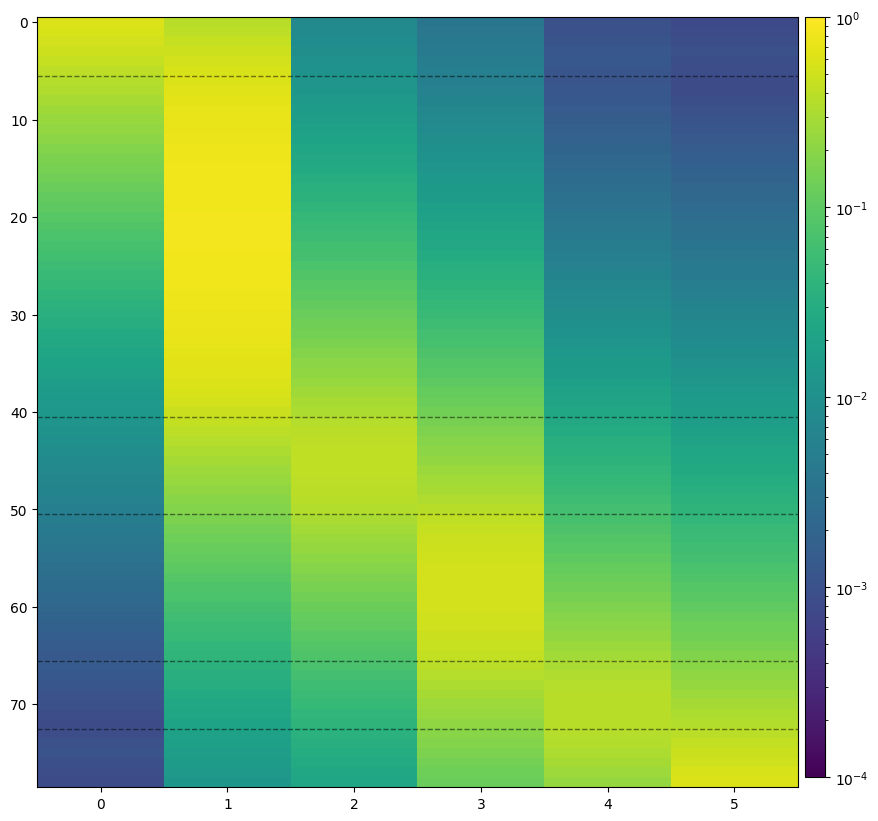

In [6]:
import matplotlib.pyplot as plt

plt.close()

fig, axis = plt.subplots(figsize=(10,10))

im = axis.imshow(final_ps, aspect=n_cats / n_seats, vmin=1e-4, vmax=1., norm='log')
for edge in cat_edges[:-1]:
    axis.axhline(edge+0.5, color='k', lw=1, ls="--", alpha=0.5)
cbar_ax = fig.add_axes([0.9, 0.12, 0.02, 0.76])
fig.colorbar(im, cax=cbar_ax)
fig.savefig("probs_matrix_opt_trust_constr.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Empirical check for DPness

Now as we have trained the utility scores, we can varify that the learned solution is DP. 
For $\epsilon$-DP, we of course require 
\begin{align}
    | \log \Pr(M(C+1) = i) - \log \Pr(M(C) = i) | \leq \epsilon,
\end{align}
for counts $C$ and $C+1$ produced by neighbouring data sets. We can verify this now simply by comparing the learned log-probabilities between concecutive counts.

In [7]:
logps = np.log(final_ps)
max_abs_logdiff_for_count = np.max(np.array([np.abs(logps[i] - logps[i+1]) for i in range(0, n_seats)]), axis=1)
print(max_abs_logdiff_for_count)
print(max_abs_logdiff_for_count.max())
print(np.max(max_abs_logdiff_for_count) < eps)

[0.09549075 0.09950787 0.09915274 0.0986312  0.09957671 0.09961247
 0.09974015 0.09987891 0.09939277 0.09976768 0.09956539 0.09990835
 0.09967184 0.09971285 0.09995651 0.09643722 0.09986305 0.09983063
 0.09887838 0.09898424 0.09995818 0.09966254 0.09905386 0.09874177
 0.09933901 0.09709501 0.09944725 0.09858322 0.09884405 0.09894991
 0.09835672 0.09975648 0.09888554 0.09904122 0.0998919  0.09925508
 0.09945965 0.09963286 0.09924519 0.0999999  0.09964406 0.09951234
 0.09965026 0.0995537  0.09941828 0.09977329 0.09969532 0.09950876
 0.09942424 0.09985816 0.09990191 0.09996903 0.09975374 0.09996891
 0.09999275 0.09944248 0.0994575  0.09963775 0.09976721 0.09994006
 0.09995437 0.09995854 0.09977913 0.09986186 0.09964335 0.09970558
 0.09965003 0.09954584 0.09937739 0.09991086 0.09953821 0.09975684
 0.09986973 0.09952545 0.09961188 0.09956276 0.09938717 0.09909618]
0.099999905
True


## Comparing the exact solution with the SGD learned one

Now lets compare three different solutions for out task: (1) the one learned using just SGD, (2) the SGD solution forced to satisfy DP and (3) the exact solution.

### (1) Solution for SGD (might violate the DP constraint)

In [8]:
logits_sgd = qs_from_sgd.reshape(n_seats+1, -1)
log_probs_sgd = jax.nn.log_softmax(logits_sgd, axis=1)

# average log-likelihood for releasing the correct category
avg_correct_sgd = (categories * log_probs_sgd).mean()
print(f"Average ll: {avg_correct_sgd}")


# DP likelihood ratio
max_abs_logdiff_for_count_sgd = np.max(
                                    np.array([np.abs(log_probs_sgd[i]-log_probs_sgd[i+1]) 
                                             for i in range(0, n_seats)]
                                            ), 
                                    axis=1
                                    )
print("Max ll ratios per count (DP constraint):\n", max_abs_logdiff_for_count_sgd)
print("Max ll ratios over counts:", max_abs_logdiff_for_count_sgd.max())

Average ll: -0.09810716658830643
Max ll ratios per count (DP constraint):
 [0.09549034 0.09950727 0.09915215 0.09863055 0.10017389 0.09964985
 0.09910405 0.09987843 0.09939241 0.09976697 0.10034359 0.09912908
 0.09967136 0.09971213 0.09995675 0.09643674 0.09986496 0.09982252
 0.09887815 0.09898376 0.0999577  0.09966683 0.09904957 0.09874082
 0.0993371  0.09709501 0.09944677 0.09858298 0.09884453 0.09894896
 0.09835625 0.099756   0.09888244 0.09904289 0.09989214 0.10003519
 0.09934831 0.09963226 0.09919167 0.09991634 0.09964383 0.10011858
 0.09987241 0.10028446 0.09975195 0.09973621 0.09969139 0.10004711
 0.10005116 0.09976864 0.09917873 0.10025454 0.09984767 0.10005426
 0.09938574 0.0994823  0.09967065 0.10022449 0.10013342 0.09991014
 0.09916592 0.09995806 0.09977853 0.0998615  0.09964287 0.1001302
 0.09979606 0.09919047 0.10009193 0.09965038 0.09953761 0.0997566
 0.09986937 0.10009748 0.10009426 0.09932995 0.09941363 0.09835529]
Max ll ratios over counts: 0.100343585


### (2) SGD solution forced to DP

In [9]:
logits_forced = qs_init_for_exact.reshape(n_seats+1, -1)
log_probs_forced = jax.nn.log_softmax(logits_forced, axis=1)

# average log-likelihood for releasing the correct category
avg_correct_forced = (categories * log_probs_forced).mean()
print(f"Average ll: {avg_correct_forced}")


# DP likelihood ratio
max_abs_logdiff_for_count_forced = np.max(
                                    np.array([np.abs(log_probs_forced[i]-log_probs_forced[i+1]) 
                                              for i in range(0, n_seats)]
                                            ), 
                                    axis=1
                                    )
print("Max ll ratios per count (DP constraint):\n", max_abs_logdiff_for_count_forced)
print("Max ll ratios over counts:", max_abs_logdiff_for_count_forced.max())

Average ll: -0.09811851382255554
Max ll ratios per count (DP constraint):
 [0.09549034 0.09950727 0.09915215 0.09863055 0.09957629 0.0996117
 0.09973979 0.09987843 0.09939241 0.09976697 0.09956479 0.09990788
 0.09967136 0.09971213 0.09995675 0.09643674 0.09986496 0.09982252
 0.09887815 0.09898376 0.0999577  0.09966683 0.09904957 0.09874082
 0.0993371  0.09709501 0.09944677 0.09858298 0.09884453 0.09894896
 0.09835625 0.099756   0.09888244 0.09904289 0.09989214 0.09925461
 0.09945881 0.09963226 0.09919167 0.09991634 0.09964383 0.0995118
 0.09964997 0.09955347 0.09939015 0.09977281 0.09969473 0.0995084
 0.09942377 0.09985614 0.09990144 0.09994316 0.09975326 0.09996819
 0.09999228 0.09944201 0.09945703 0.09963727 0.09976673 0.09993935
 0.09995401 0.09995806 0.09977853 0.0998615  0.09964287 0.09962881
 0.09964955 0.09954536 0.09937692 0.09991026 0.09953761 0.0997566
 0.09986937 0.09952503 0.09961176 0.09956193 0.09938669 0.09909511]
Max ll ratios over counts: 0.099992275


### (3) Solution from constrained optimization using previous as initial value

In [10]:
logits_exact = res.x.reshape(n_seats+1, -1)
log_probs_exact = jax.nn.log_softmax(logits_exact, axis=1)

# average log-likelihood for releasing the correct category
avg_correct_exact = (categories * log_probs_exact).mean()
print(f"Average ll: {avg_correct_exact}")


# DP likelihood ratio
max_abs_logdiff_for_count_exact = np.max(
                                    np.array([np.abs(log_probs_exact[i]-log_probs_exact[i+1]) 
                                              for i in range(0, n_seats)]
                                            ), 
                                    axis=1
                                    )
print("Max ll ratios per count (DP constraint):\n", max_abs_logdiff_for_count_exact)
print("Max ll ratios over counts:", max_abs_logdiff_for_count_exact.max())

Average ll: -0.09810524433851242
Max ll ratios per count (DP constraint):
 [0.09549069 0.09950793 0.09915274 0.0986312  0.09957677 0.09961241
 0.09974015 0.09987891 0.09939277 0.09976757 0.09956551 0.09990835
 0.09967184 0.09971273 0.09995627 0.09643722 0.09986305 0.09983063
 0.09887838 0.09898424 0.09995818 0.0996623  0.0990541  0.09874177
 0.09933901 0.09709501 0.09944725 0.09858322 0.09884429 0.09894991
 0.09835672 0.09975648 0.09888566 0.0990411  0.0998919  0.0992552
 0.09945965 0.09963286 0.09924519 0.0999999  0.09964406 0.0995124
 0.0996502  0.0995537  0.09941816 0.09977341 0.09969521 0.099509
 0.09942412 0.09985816 0.09990197 0.09996915 0.09975374 0.09996891
 0.09999263 0.09944272 0.09945726 0.09963775 0.09976697 0.09993994
 0.09995437 0.09995866 0.09977913 0.09986186 0.09964347 0.09970558
 0.09965008 0.09954584 0.09937716 0.09991086 0.09953821 0.09975684
 0.09986973 0.09952545 0.09961188 0.09956276 0.09938717 0.09909606]
Max ll ratios over counts: 0.099999905
